In [1]:
import os
from dataclasses import dataclass
from urllib.parse import quote_plus
import nest_asyncio

import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder, TargetEncoder, SumEncoder, QuantileEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from forestci import random_forest_error

from pc_zap_scrapper.v2.database import DatabaseHandler, TableRealEstateInfo

In [2]:
from dataclasses import dataclass

import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit, GroupKFold

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import KBinsDiscretizer


sklearn.set_config(transform_output="pandas")

pd.options.display.max_columns = None

# Functions

In [3]:
def predict_interval(X, pipeline, quantile = [0.25, 0.5, 0.75]):
    all_tree_predictions = pd.DataFrame([tree.predict(X.values) for tree in pipeline.named_steps['regressor'].estimators_])
    response = all_tree_predictions.quantile(quantile).T
    response.columns = ["lower", "median", "upper"]
    return response


In [52]:
import numpy as np
import pandas as pd
import ast


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")
        return X[self.columns].copy()


class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if not np.issubdtype(X[self.date_column].dtype, np.datetime64):
            X[self.date_column] = pd.to_datetime(X[self.date_column], errors='coerce')
        if X[self.date_column].isnull().any():
            raise ValueError("Há valores nulos ou formatos inválidos na coluna de data após a conversão.")
        X['year'] = X[self.date_column].dt.year
        X['month'] = X[self.date_column].dt.month
        X['day'] = X[self.date_column].dt.day
        X['week_number'] = X[self.date_column].dt.isocalendar().week

        X = X.drop(columns=[self.date_column])

        return X

class AmenitiesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, amenities_column='amenities_list', relevant_amenities=None):
        self.amenities_column = amenities_column
        self.relevant_amenities = relevant_amenities

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X = X.copy()
        relevant_amenities = np.array(self.relevant_amenities)

        def crate_amenities_encoding(x):
            if not x:
                return np.zeros(len(relevant_amenities), dtype=int)
            try:
                estate_amenities = ast.literal_eval(x)
                return np.isin(relevant_amenities, estate_amenities).astype(int)
            except (ValueError, SyntaxError):
                return np.zeros(len(relevant_amenities), dtype=int)

        amenities_encoded_list = X[self.amenities_column].apply(crate_amenities_encoding).tolist()
        amenities_encoded = pd.DataFrame(amenities_encoded_list, columns=relevant_amenities)

        # Concatenar as novas colunas ao DataFrame original
        X.reset_index(drop=True, inplace=True)
        amenities_encoded.reset_index(drop=True, inplace=True)
        X = pd.concat([X, amenities_encoded], axis=1)

        # Remover a coluna original de amenidades, se desejar
        X.drop(columns=[self.amenities_column], inplace=True)

        return X



class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_bins=5, encode='ordinal', strategy='quantile'):
        self.columns = columns
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.discretizer_ = None

    def fit(self, X, y=None):
        # Verificar se todas as colunas existem no DataFrame
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")

        # Ajustar o discretizador apenas com as colunas selecionadas
        self.discretizer_ = KBinsDiscretizer(n_bins=self.n_bins, encode=self.encode, strategy=self.strategy)
        self.discretizer_.fit(X[self.columns])

        return self

    def transform(self, X):
        X = X.copy()
        # Verificar novamente se todas as colunas estão presentes
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")

        # Aplicar o discretizador às colunas
        transformed_values = self.discretizer_.transform(X[self.columns])
        
        # Se o encode for 'ordinal', a saída é um array 2D com os buckets, substituímos diretamente
        # Se for 'onehot' ou 'onehot-dense', teremos mais colunas do que inicialmente
        # Nesse caso, é necessário criar novas colunas. Aqui vamos lidar apenas com 'ordinal' para simplificar.
        if self.encode == 'ordinal':
            X[self.columns] = transformed_values
        else:
            # Caso onehot, criamos um DataFrame separado e concatenamos
            # Os nomes das colunas podem ser gerados a partir das colunas originais + índices dos bins
            bin_column_names = []
            for col_idx, col_name in enumerate(self.columns):
                for bin_idx in range(self.n_bins):
                    bin_column_names.append(f"{col_name}_bin_{bin_idx}")
            
            onehot_df = pd.DataFrame(transformed_values, columns=bin_column_names, index=X.index)
            # Remover as colunas originais e concatenar as novas
            X.drop(columns=self.columns, inplace=True)
            X = pd.concat([X, onehot_df], axis=1)

        return X


In [53]:
def grouped_train_test_split(df: pd.DataFrame, groups: pd.Series, test_size: float, random_state: float | None = None):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)    
    train_idx, test_idx = next(gss.split(df, groups=groups))
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)
    return df_train, df_test


def set_k_train_folds(df_train, index_column, target_column, n_folds):
    folds = [Fold(df_train, train_index, val_index) for train_index, val_index in GroupKFold(n_splits=n_folds).split(df_train, groups=df_train[index_column])]
    return folds


@dataclass
class Fold:
    data_train: pd.DataFrame
    data_val: pd.DataFrame

    def __init__(self, df, train_index, val_index):
        self.data_train = df.iloc[train_index]
        self.data_val = df.iloc[val_index]


# Dados

In [6]:

db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)

sql_query = """
SELECT * FROM real_estate_info
"""

data_raw = await db_handler.query(sql_query)

await db_handler.close()


In [7]:
1

1

# Data Cleaning

In [8]:
N_FOLDS = 5

# Não podemos usar o index do dataframe. Esse é o index no imóvel,
# que pode aparecer mais de uma vez no dataframe
INDEX_COLUMN = 'estate_id'

TARGET_COLUMN = 'price'

In [9]:
data = data_raw.copy()
data = data.loc[~data[TARGET_COLUMN].isna()]
data = data.loc[data[TARGET_COLUMN] > 0]
data[TARGET_COLUMN] = data[TARGET_COLUMN].astype(float)

data = data[data["price"] < 10_000_000]

data["link"] = data["link"].where(data["link"].str[:29]=="https://www.zapimoveis.com.br", "https://www.zapimoveis.com.br" +  data["link"])

INFERED_TYPES = [
    'apartamento', 'casa', 'terreno', 'fazenda', 'loja', 'sobrados',
    'galpao', 'conjunto', 'cobertura', 'studio', 'flat', 'quitinete',
    'chacara',
]

data["infered_type"] = data["link"]
data["infered_type"] = np.where(data["infered_type"].str[:30]=="https://www.zapimoveis.com.br/", data["infered_type"].str.replace("https://www.zapimoveis.com.br", ""), data["infered_type"])
data["infered_type"] = np.where(data["infered_type"].str[:11] == "/lancamento", data["infered_type"].str.replace("/lancamento", ""), data["infered_type"])
data["infered_type"] = data["infered_type"].str.replace("/imovel", "")
data["infered_type"] = data["infered_type"].str.replace("/venda", "")
data["infered_type"] = np.where(data["infered_type"].str[:1] == "-", data["infered_type"].str[1:], data["infered_type"])
data["infered_type"] = data["infered_type"].str.split("-").str[0]
data["infered_type"] = data["infered_type"].where(data["infered_type"].isin(INFERED_TYPES), "outro")

data = data.loc[data["infered_type"].isin(["casa", "apartamento", "terreno"])]


data["floor_size"] = data["floor_size"].where((data["floor_size"] >= 30) & (data["floor_size"] <= 5400), None)

# casas.loc[casas["floor_size"] > 10000, "floor_size"] = np.nan
# casas = casas.loc[casas["floor_size"] < 1100]

data["number_of_rooms"] = data["number_of_rooms"].clip(1,10)
data["number_of_bathrooms"] = data["number_of_bathrooms"].clip(1,6)
data["number_of_parking_spaces"] = data["number_of_parking_spaces"].clip(0,6)

# teste
# casas = casas.loc[casas["price"] <= 2_500_000]

In [10]:
# Não podemos usar o index do dataframe. Esse é o index no imóvel,
# que pode aparecer mais de uma vez no dataframe
INDEX_COLUMN = 'estate_id'
N_FOLDS = 5
TEST_SIZE = 0.2

data_train_full, data_test = grouped_train_test_split(data, groups=data[INDEX_COLUMN], test_size=TEST_SIZE, random_state=42)


data_train, data_cal = grouped_train_test_split(data_train_full, groups=data_train_full[INDEX_COLUMN], test_size=TEST_SIZE, random_state=42)


train_folds = set_k_train_folds(data_train, index_column=INDEX_COLUMN, target_column=TARGET_COLUMN, n_folds=N_FOLDS)

In [11]:
import seaborn as sns

regplot_opts = dict(
    line_kws={"color": "red", "linewidth": 2},
    scatter_kws={"alpha": 0.01, "edgecolor": "none", "s":5},
)


mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-974wds_b because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<Axes: xlabel='floor_size', ylabel='price'>

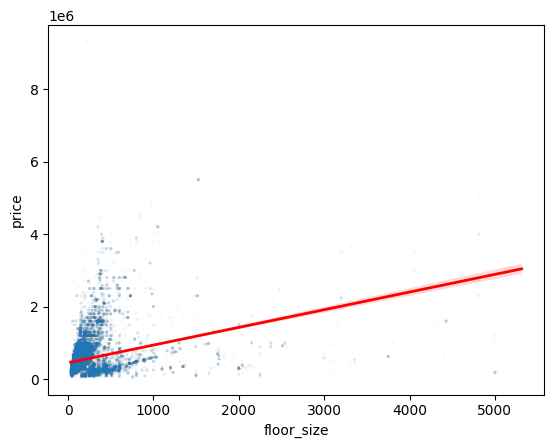

In [12]:

sns.regplot(data=data, x="floor_size", y="price", **regplot_opts)

<Axes: xlabel='number_of_rooms', ylabel='price'>

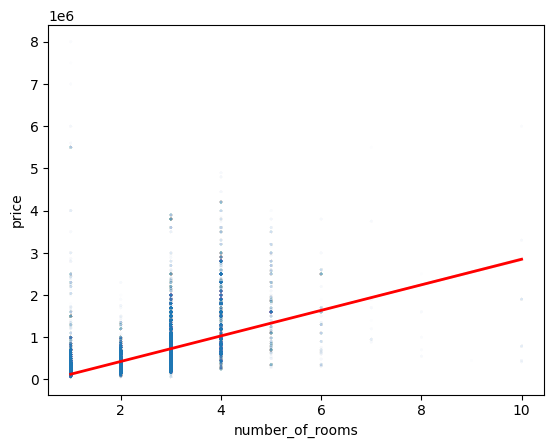

In [13]:
sns.regplot(data=data, x="number_of_rooms", y="price", **regplot_opts)

# Modelling

# Visão Geral

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


selected_columns = [
    'search_date',
    'type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'amenities_list',
    'condominium',
    'iptu',
]


categorical_columns = [
    "type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]

relevant_amenities = [
    'FIREPLACE',
    'POOL',
    'DINNER_ROOM',
    'HOME_OFFICE',
    'BACKYARD',
    'INTERCOM',
    'ELEVATOR',
    'LAUNDRY',
    'CLOSET',
    'GATED_COMMUNITY',
    'KITCHEN',
    'GOURMET_BALCONY',
    'SERVICE_AREA',
    'BARBECUE_GRILL',
    'BALCONY',
    'ALARM_SYSTEM',
    'SPORTS_COURT',
    'DEPOSIT',
    'NUMBER_OF_FLOORS',
    'GARDEN',
    'HEATING',
    'SAUNA',
    'Condomínio fechado',
    'PARTY_HALL',
    'GOURMET_SPACE',
    'CABLE_TV',
    'COPA',
    'FURNISHED',
    'MOUNTAIN_VIEW',
    'BUILTIN_WARDROBE',
]



pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('amenities_encoder', AmenitiesEncoder(
        amenities_column='amenities_list',
        relevant_amenities=relevant_amenities
    )),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', MinMaxScaler()),
])


In [56]:
%%time

from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

metrics = []

models = {
    "catboost": CatBoostRegressor(random_state=42, verbose=0),
    "random_forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "linear_regression": LinearRegression(),
    "decision_tree": DecisionTreeRegressor(),
    "hist_gradient_boosting": HistGradientBoostingRegressor(),
    "xgboost": XGBRegressor(random_state=42),
    "lightgbm": LGBMRegressor(random_state=42),
    "adaboost": AdaBoostRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
}

for label, model in tqdm(models.items(), desc="Model"):
    fold_metrics = []
    for fold in tqdm(train_folds, desc="Fold", leave=False):
        data_train = fold.data_train
        data_val = fold.data_val

        X_train = data_train.drop(columns=TARGET_COLUMN)
        X_val = data_val.drop(columns=TARGET_COLUMN)

        y_train = data_train[TARGET_COLUMN]
        y_val = data_val[TARGET_COLUMN]

        pipeline.fit(X_train, y_train)

        X_train_processed = pipeline.transform(X_train)
        X_val_processed = pipeline.transform(X_val)

        model.fit(X_train_processed, y_train)

        y_train_predicted = model.predict(X_train_processed)
        y_val_predicted = model.predict(X_val_processed)

        fold_metrics.append(
            {
                "mae_train": mean_absolute_error(y_train, y_train_predicted),
                "mae_val": mean_absolute_error(y_val, y_val_predicted),
                "r2_train": r2_score(y_train, y_train_predicted),
                "r2_val": r2_score(y_val, y_val_predicted),
            }
        )

    metrics_agg = pd.DataFrame(fold_metrics).mean().to_dict()
    metrics_agg.update({"label": label})
    print(metrics_agg)
    metrics.append(metrics_agg)


Model:  11%|█         | 1/9 [00:52<07:00, 52.59s/it][A

{'mae_train': 69156.07937565896, 'mae_val': 119772.64746426197, 'r2_train': 0.9447606926563343, 'r2_val': 0.7189596865036343, 'label': 'catboost'}



Model:  22%|██▏       | 2/9 [02:40<09:57, 85.41s/it][A

{'mae_train': 9018.35803306277, 'mae_val': 106464.24840700459, 'r2_train': 0.9931991433231655, 'r2_val': 0.7159326137129657, 'label': 'random_forest'}



Model:  33%|███▎      | 3/9 [03:03<05:41, 56.86s/it][A

{'mae_train': 176568.9654671134, 'mae_val': 186137.94941095888, 'r2_train': 0.6006191855522799, 'r2_val': -1.8025126818491262, 'label': 'linear_regression'}



Model:  44%|████▍     | 4/9 [03:27<03:39, 43.91s/it][A

{'mae_train': 2239.3862702496617, 'mae_val': 133414.3437531888, 'r2_train': 0.9980144193462912, 'r2_val': 0.4636404093561568, 'label': 'decision_tree'}



Model:  56%|█████▌    | 5/9 [03:55<02:32, 38.17s/it][A

{'mae_train': 88310.22933062266, 'mae_val': 125626.0448068548, 'r2_train': 0.8957850102015726, 'r2_val': 0.7279052098077228, 'label': 'hist_gradient_boosting'}



Model:  67%|██████▋   | 6/9 [04:21<01:41, 33.94s/it][A

{'mae_train': 57585.127265926465, 'mae_val': 118506.5362331098, 'r2_train': 0.9575671578487011, 'r2_val': 0.7142722508511729, 'label': 'xgboost'}



Fold:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 49960, number of used features: 14
[LightGBM] [Info] Start training from score 562561.923239



Fold:  20%|██        | 1/5 [00:04<00:19,  4.77s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 49961, number of used features: 14
[LightGBM] [Info] Start training from score 554651.664879



Fold:  40%|████      | 2/5 [00:09<00:14,  4.79s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 49961, number of used features: 14
[LightGBM] [Info] Start training from score 556514.919837



Fold:  60%|██████    | 3/5 [00:14<00:09,  4.78s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 49961, number of used features: 14
[LightGBM] [Info] Start training from score 559980.224475



Fold:  80%|████████  | 4/5 [00:19<00:04,  4.77s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 49961, number of used features: 14
[LightGBM] [Info] Start training from score 556373.558676



Model:  78%|███████▊  | 7/9 [04:45<01:01, 30.66s/it][A

{'mae_train': 86784.7614585055, 'mae_val': 124446.08583649181, 'r2_train': 0.9059009715713117, 'r2_val': 0.7338743142345695, 'label': 'lightgbm'}



Model:  89%|████████▉ | 8/9 [05:15<00:30, 30.34s/it][A

{'mae_train': 332276.79235443485, 'mae_val': 338286.7871855713, 'r2_train': 0.24883995935575864, 'r2_val': 0.12455118973452455, 'label': 'adaboost'}



Model: 100%|██████████| 9/9 [05:57<00:00, 39.76s/it][A

{'mae_train': 123327.61818854828, 'mae_val': 141717.83299980627, 'r2_train': 0.8011918706588693, 'r2_val': 0.6837970472163738, 'label': 'gradient_boosting'}
CPU times: user 9min 36s, sys: 32.4 s, total: 10min 8s
Wall time: 5min 57s


In [33]:
pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    # ('amenities_encoder', AmenitiesEncoder(
    #     amenities_column='amenities_list',
    #     relevant_amenities=relevant_amenities
    # )),
    # ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    # ('scaler', MinMaxScaler()),
])


X_train_transf = pipeline.fit_transform(X_train, y_train)


In [37]:
import numpy as np
import pandas as pd
import ast

class AmenitiesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, amenities_column='amenities_list', relevant_amenities=None):
        self.amenities_column = amenities_column
        self.relevant_amenities = relevant_amenities

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        relevant_amenities = np.array(self.relevant_amenities)
        def crate_amenities_encoding(x):
            if not x or pd.isna(x):
                return np.zeros(len(relevant_amenities), dtype=int)
            try:
                estate_amenities = ast.literal_eval(x)
                return np.isin(relevant_amenities, estate_amenities).astype(int)
            except (ValueError, SyntaxError):
                return np.zeros(len(relevant_amenities), dtype=int)
        amenities_encoded_list = X[self.amenities_column].apply(crate_amenities_encoding).tolist()
        # amenities_encoded = pd.DataFrame(amenities_encoded_list, columns=relevant_amenities)
        # X.reset_index(drop=True, inplace=True)
        # amenities_encoded.reset_index(drop=True, inplace=True)
        # X = pd.concat([X, amenities_encoded], axis=1)
        # X.drop(columns=[self.amenities_column], inplace=True)

        return X

# amenities_encoder = AmenitiesEncoder(
#     amenities_column='amenities_list',
#     relevant_amenities=relevant_amenities,
# )


# X_train_transf = amenities_encoder.fit_transform(X_train_transf, y_train)

In [50]:
X = X_train_transf

def crate_amenities_encoding(x):
    print(x)
    cond = (not x) or pd.isna(x)
    print(cond)
    raise Exception()
    if (not x) or pd.isna(x):
        return np.zeros(len(relevant_amenities), dtype=int)
    # try:
    #     estate_amenities = ast.literal_eval(x)
    #     return np.isin(relevant_amenities, estate_amenities).astype(int)
    # except (ValueError, SyntaxError):
    #     return np.zeros(len(relevant_amenities), dtype=int)
    
amenities_encoded_list = X['amenities_list'].apply(crate_amenities_encoding).tolist()

amenities_encoded_list

['Cozinha', 'Elevador', 'Interfone', 'Área de serviço']
[False False False False]


Exception: 

In [41]:
X['amenities_list']

0        [Cozinha, Elevador, Interfone, Área de serviço]
4                                            [TV à cabo]
5                                                   None
6                                 [Cozinha, Aquecimento]
7                                                   None
                              ...                       
62442                                               None
62446                                               None
62447                                               None
62449                                               None
62450                                               None
Name: amenities_list, Length: 49961, dtype: object